# WIND TURBINES PREDICTIVE MAINTENANCE THROUGH ML: DATA EXPLORATION - SOLUTION (2)

# Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
sns.set_style('darkgrid')

# 1) Load data

In [2]:
DATA_ROOT = "Training/"
DATA_SIGNAL = "Training_signals.csv"
DATA_CLEAN_ROOT = 'data_clean'
DATA_PROD_CLEAN = 'turbines_df.p'
DATA_MAST_CLEAN = 'mast.p'
DATA_FAILURE = 'Training_failures.csv'

In [3]:
df = pd.read_pickle(os.path.join(DATA_CLEAN_ROOT, DATA_PROD_CLEAN))
mast = pd.read_pickle(os.path.join(DATA_CLEAN_ROOT, DATA_MAST_CLEAN))

In [4]:
turbines = df.index.get_level_values('Turbine_ID').unique()

In [5]:
turbines

Index(['T01', 'T06', 'T07', 'T09', 'T11'], dtype='object', name='Turbine_ID')

# 2) Produced energy

In [6]:
df.head()

Unnamed: 0  Gen_RPM_Max  Gen_RPM_Min  \
Turbine_ID Timestamp                                                         
T01        2016-01-01 00:00:00+00:00           2       1277.4       1226.1   
           2016-01-01 00:10:00+00:00           8       1268.3         93.3   
           2016-01-01 00:20:00+00:00          13       1394.4        220.3   
           2016-01-01 00:30:00+00:00          15       1306.6       1212.4   
           2016-01-01 00:40:00+00:00          21       1320.9       1224.1   

                                      Gen_RPM_Avg  Gen_RPM_Std  \
Turbine_ID Timestamp                                             
T01        2016-01-01 00:00:00+00:00       1249.0          9.0   
           2016-01-01 00:10:00+00:00        999.7        435.9   
           2016-01-01 00:20:00+00:00        774.0        486.1   
           2016-01-01 00:30:00+00:00       1257.1         17.0   
           2016-01-01 00:40:00+00:00       1257.7         18.0   

                                      Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
Turbine_ID Timestamp                                                           
T01        2016-01-01 00:00:00+00:00               41.0                   58   
           2016-01-01 00:10:00+00:00               41.0                   58   
           2016-01-01 00:20:00+00:00               41.0                   57   
           2016-01-01 00:30:00+00:00               40.0                   56   
           2016-01-01 00:40:00+00:00               40.0                   57   

                                      Gen_Phase2_Temp_Avg  \
Turbine_ID Timestamp                                        
T01        2016-01-01 00:00:00+00:00                   59   
           2016-01-01 00:10:00+00:00                   59   
           2016-01-01 00:20:00+00:00                   57   
           2016-01-01 00:30:00+00:00                   57   
           2016-01-01 00:40:00+00:00                   58   

                                      Gen_Phase3_Temp_Avg  Hyd_Oil_Temp_Avg  \
Turbine_ID Timestamp                                                          
T01        2016-01-01 00:00:00+00:00                   58                30   
           2016-01-01 00:10:00+00:00                   59                30   
           2016-01-01 00:20:00+00:00                   57                30   
           2016-01-01 00:30:00+00:00                   57                30   
           2016-01-01 00:40:00+00:00                   57                30   

                                      ...  Grd_Prod_PsbleInd_Avg  \
Turbine_ID Timestamp                  ...                          
T01        2016-01-01 00:00:00+00:00  ...                 -144.4   
           2016-01-01 00:10:00+00:00  ...                  -79.6   
           2016-01-01 00:20:00+00:00  ...                 -314.0   
           2016-01-01 00:30:00+00:00  ...                 -654.0   
           2016-01-01 00:40:00+00:00  ...                 -496.1   

                                      Grd_Prod_PsbleInd_Max  \
Turbine_ID Timestamp                                          
T01        2016-01-01 00:00:00+00:00                    0.0   
           2016-01-01 00:10:00+00:00                    0.0   
           2016-01-01 00:20:00+00:00                    0.0   
           2016-01-01 00:30:00+00:00                    0.0   
           2016-01-01 00:40:00+00:00                    0.0   

                                      Grd_Prod_PsbleInd_Min  \
Turbine_ID Timestamp                                          
T01        2016-01-01 00:00:00+00:00                 -584.5   
           2016-01-01 00:10:00+00:00                 -501.0   
           2016-01-01 00:20:00+00:00                -1000.0   
           2016-01-01 00:30:00+00:00                -1000.0   
           2016-01-01 00:40:00+00:00                -1000.0   

                                      Grd_Prod_PsbleInd_Std  \
Turbine_ID Timestamp                                         

## a) Total energy in a year

Here, we want to compare the energy produced by the five turbines in a year.
The energy (in kWh) is defined as power (in kW) * time (in h). 
Since we have measureaments of power (*Grd_Prod_Pwr_Avg* [kW]) every 10 minutes (1/6 of an hour), 
we can get the energy produced in kWh by dividing by 6.

In [7]:
energy_yearly = df.reset_index(level=0).groupby('Turbine_ID') \
    ['Grd_Prod_Pwr_Avg'].sum() / 6

In [8]:
energy_yearly

Turbine_ID
T01    4.314752e+06
T06    4.289387e+06
T07    4.602257e+06
T09    4.294874e+06
T11    4.750355e+06
Name: Grd_Prod_Pwr_Avg, dtype: float64

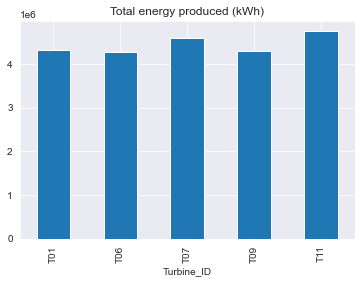

In [9]:
energy_yearly.plot(kind='bar', title='Total energy produced (kWh)')
plt.show()

From this bar plot, wa can note that there are some small differences in the energy produced in a year. For more details, we need to explore the produced energy of each turbine across different months.

## b) Energy for each turbine by month

In [10]:
# Let's group the data by turbine, and then resample by month
energy_monthly = df.reset_index(level=0).groupby(
    'Turbine_ID')['Grd_Prod_Pwr_Avg'].apply(lambda x: (x/6).resample('M').sum())

In [11]:
energy_monthly

Turbine_ID  Timestamp                
T01         2016-01-31 00:00:00+00:00    266150.433333
            2016-02-29 00:00:00+00:00    504104.316667
            2016-03-31 00:00:00+00:00    161575.766667
            2016-04-30 00:00:00+00:00    242396.833333
            2016-05-31 00:00:00+00:00    431164.283333
            2016-06-30 00:00:00+00:00    363623.516667
            2016-07-31 00:00:00+00:00    390518.783333
            2016-08-31 00:00:00+00:00    516233.733333
            2016-09-30 00:00:00+00:00    352781.250000
            2016-10-31 00:00:00+00:00    357829.650000
            2016-11-30 00:00:00+00:00    266574.583333
            2016-12-31 00:00:00+00:00    461799.300000
T06         2016-01-31 00:00:00+00:00    263582.133333
            2016-02-29 00:00:00+00:00    506173.983333
            2016-03-31 00:00:00+00:00    159376.383333
            2016-04-30 00:00:00+00:00    230752.166667
            2016-05-31 00:00:00+00:00    447178.900000
            2016-06-30 00:0

In [12]:
energy_monthly = energy_monthly.unstack() / 1000 #Pivot a level of the (necessarily hierarchical) index labels.

In [13]:
energy_monthly

Timestamp,2016-01-31 00:00:00+00:00,2016-02-29 00:00:00+00:00,2016-03-31 00:00:00+00:00,2016-04-30 00:00:00+00:00,2016-05-31 00:00:00+00:00,2016-06-30 00:00:00+00:00,2016-07-31 00:00:00+00:00,2016-08-31 00:00:00+00:00,2016-09-30 00:00:00+00:00,2016-10-31 00:00:00+00:00,2016-11-30 00:00:00+00:00,2016-12-31 00:00:00+00:00
Turbine_ID,,,,,,,,,,,,
T01,266.150433,504.104317,161.575767,242.396833,431.164283,363.623517,390.518783,516.233733,352.781250,357.829650,266.574583,461.799300
T06,263.582133,506.173983,159.376383,230.752167,447.178900,401.544283,239.672967,675.022000,374.714933,231.070250,250.567767,509.731283
T07,288.717000,523.859850,167.171817,235.264367,479.370383,405.632617,458.318050,512.481283,318.412467,366.693700,308.856750,537.478483
T09,271.385467,476.925050,141.190417,235.792817,335.788883,344.395367,467.182683,566.175933,328.508183,356.811900,284.227400,486.490100
T11,315.938683,537.889617,167.187783,259.659017,457.624633,373.001467,490.167517,586.104233,356.535750,367.000967,323.963550,515.281300


Now we can deduce which turbine produced the biggest amount of energy for each month.

In [14]:
energy_monthly.idxmax()  #Return index of first occurrence of maximum over requested axis.

Timestamp
2016-01-31 00:00:00+00:00    T11
2016-02-29 00:00:00+00:00    T11
2016-03-31 00:00:00+00:00    T11
2016-04-30 00:00:00+00:00    T11
2016-05-31 00:00:00+00:00    T07
2016-06-30 00:00:00+00:00    T07
2016-07-31 00:00:00+00:00    T11
2016-08-31 00:00:00+00:00    T06
2016-09-30 00:00:00+00:00    T06
2016-10-31 00:00:00+00:00    T11
2016-11-30 00:00:00+00:00    T11
2016-12-31 00:00:00+00:00    T07
Freq: M, dtype: object

Since we have two dimensions: turbines and months, we can plot a heatmap to better vizualize how much energy was produced by each turbine in the different months.

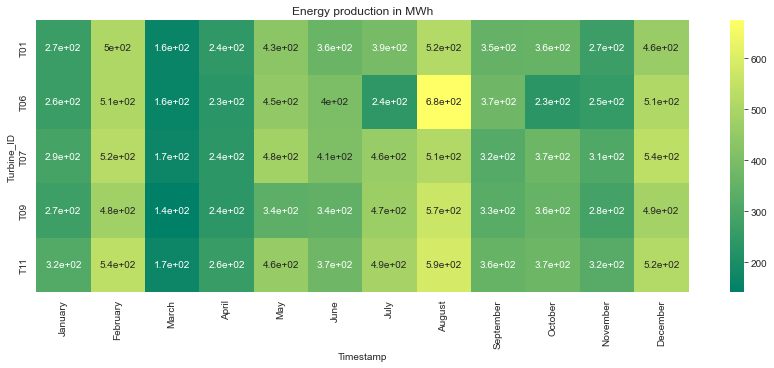

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(energy_monthly, annot=True, cmap='summer', square=True)
ax.set_title('Energy production in MWh')
ax.set_xticklabels(energy_monthly.columns.month_name())
plt.show()

We can also use a simple bar chart.

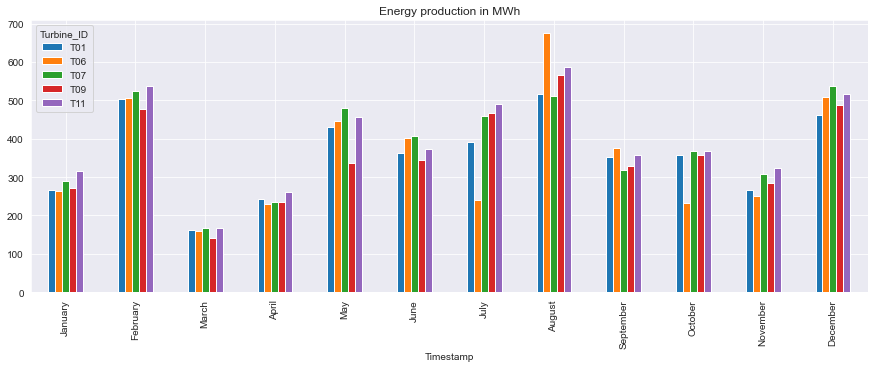

In [16]:
fig, ax = plt.subplots(figsize=(15,5))
energy_monthly.T.plot(kind='bar', ax=ax)  #transpose the data
ax.set_title('Energy production in MWh')
ax.set_xticklabels(energy_monthly.columns.month_name())
plt.show()

For the first 4 months, we can see that the energy production is almost the same for the turbines. However, we can note that there is a small energy production in March and April. This can be explained by the failure that occured on Turbine T11 in March and also the hydraulic group and generator bearing failures in April for Turbines T06 and T07 respectivey (See below: Section failures). 

Let's check the energy produced by the turbines at different hours of the day.

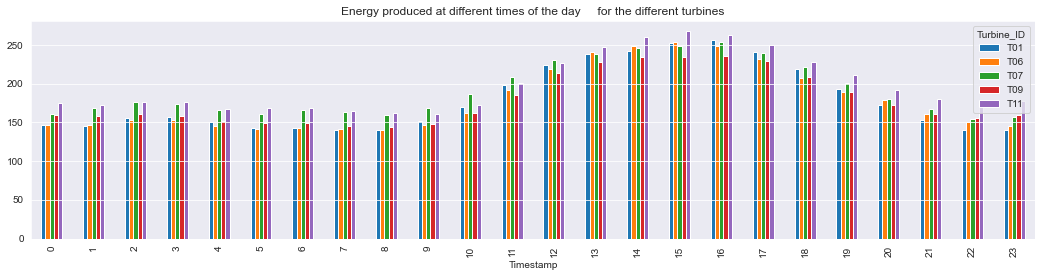

In [17]:
# we'll group the data by turbine and resample per hour
energy_hourly_sum = df.reset_index(level=0).groupby(
    'Turbine_ID')['Grd_Prod_Pwr_Avg'].apply(
    lambda x: (x/6).groupby(x.index.hour).sum())

energy_hourly_sum = energy_hourly_sum.unstack() / 1000


fig, ax = plt.subplots(figsize=(18,4))
energy_hourly_sum.T.plot(kind='bar', ax=ax, zorder=-1)
ax.xaxis.grid(False)  #Configure the grid lines.
ax.set_title('Energy produced at different times of the day \
    for the different turbines')
plt.show()

We can represent this information using a heatmap as before since we have two dimensions: the different turbines and the hours.

<AxesSubplot:xlabel='Timestamp', ylabel='Turbine_ID'>

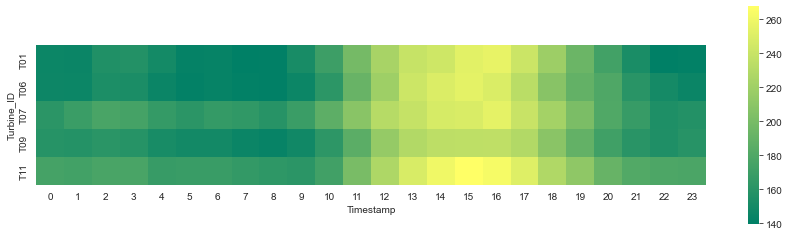

In [18]:
fig, ax = plt.subplots(figsize=(15,4))
sns.heatmap(energy_hourly_sum, ax=ax, square=True, cmap='summer')

Now, let's represent the evolution of the energy produced by each turbine for each month using a classical lineplot.

c:\users\suley\documents\github\windfarmproject\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\suley\documents\github\windfarmproject\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\suley\documents\github\windfarmproject\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

c:\users\suley\documents\github\windfarmproject\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\suley\documents\github\windfarmproject\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\suley\documents\github\windfarmproject\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

c:\users\suley\documents\github\windfarmproject\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\suley\documents\github\windfarmproject\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\suley\documents\github\windfarmproject\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

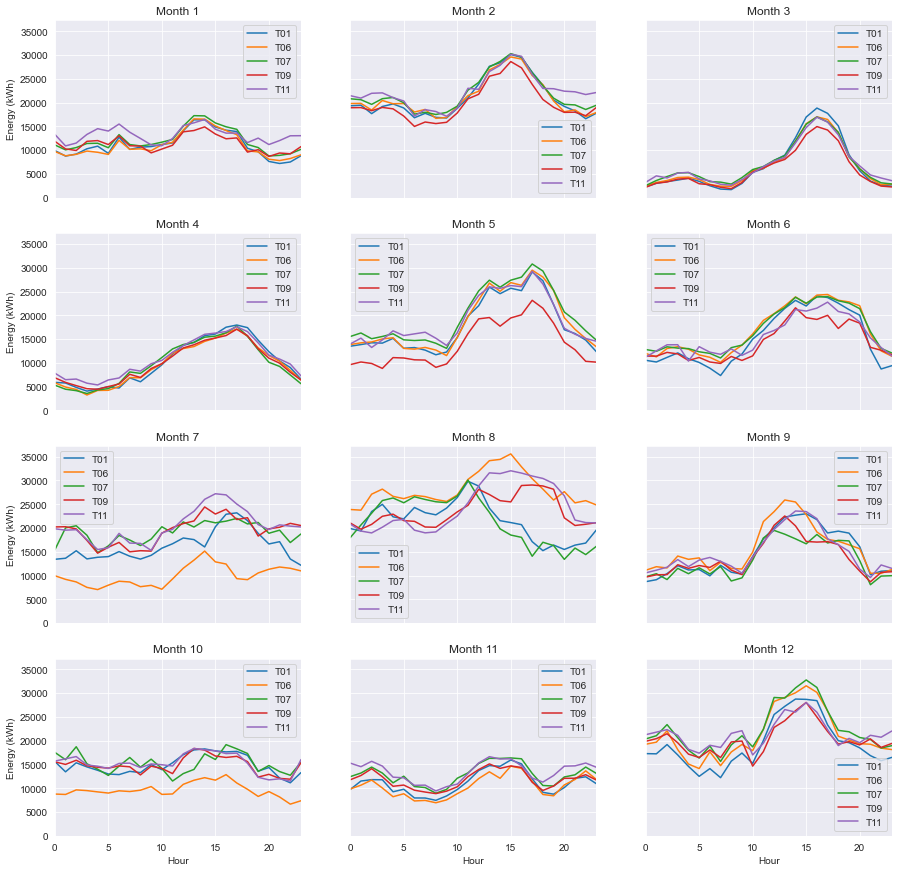

In [19]:
df_ = df.reset_index(level=0)
energy_monthly_hourly = df_.groupby(df_.Turbine_ID).Grd_Prod_Pwr_Avg.apply(
    lambda x: x.groupby(x.index.month).apply(
    lambda y: (y/6).groupby(y.index.hour).sum()))
del df_


fig, axes = plt.subplots(figsize=(15,15), nrows=4, ncols=3, 
                         sharex=True, sharey=True)

for i in range(12):
    ax = axes.ravel()[i]
    month = i+1
    for turbine in turbines:
        turbine_monthly_hourly_consumption = energy_monthly_hourly \
            .loc[turbine].loc[month]
        
        sns.lineplot(
            turbine_monthly_hourly_consumption.index, 
            turbine_monthly_hourly_consumption.values, 
            label=turbine, ax=ax)
        ax.set_xlim(0,23)
        ax.set_title(f'Month {month}')
        ax.set_xlabel('Hour')
        ax.set_ylabel('Energy (kWh)')

We can see that Turbine 6 is producing less energy that the other turbines during several months. We can also note that the turbines are producing more energy during certain seasons and less during others.

# 3) Failures

Exploring available failures data is very important. It will give us some insights and information about predicting failures before they happen in the future.

In [20]:
#load the failures dataset
failures = pd.read_csv(os.path.join(DATA_ROOT, DATA_FAILURE), delimiter=',')
failures.Timestamp = pd.to_datetime(failures.Timestamp)

In [21]:
failures.head()

,Unnamed: 0,Turbine_ID,Component,Timestamp,Remarks
0,0,T11,GENERATOR,2016-03-03 19:00:00+00:00,Electric circuit error in generator
1,1,T06,HYDRAULIC_GROUP,2016-04-04 18:53:00+00:00,Error in pitch regulation
2,2,T07,GENERATOR_BEARING,2016-04-30 12:40:00+00:00,High temperature in generator bearing (replace...
3,3,T09,GENERATOR_BEARING,2016-06-07 16:59:00+00:00,High tempemperature generator bearing
4,4,T07,TRANSFORMER,2016-07-10 03:46:00+00:00,High temperature transformer


Failures data shows which component failed in which turbine and gives information about the time when the failure occurs and some remarks about the failure.

## a) Failures/turbine

Let's see how many failures occured in each turbine.

In [22]:
failures.Turbine_ID.value_counts()

T06    6
T09    4
T07    3
T11    2
T01    1
Name: Turbine_ID, dtype: int64

It seems that Turbine 06 had 6 failures during the year while Turbine 01 had only one failure.

In [23]:
failures = failures.loc[failures.Turbine_ID.isin(turbines)]

## b) Failures/components

Now, let's see how many failures occured on each component.

In [24]:
failures.Component.value_counts()

GENERATOR            6
GENERATOR_BEARING    4
HYDRAULIC_GROUP      2
TRANSFORMER          2
GEARBOX              2
Name: Component, dtype: int64

The generator failed 6 times during the year while the generator bearing failed 4 times. This can indicate that we should "focus" on these components that tend to fail often.

If we assume that the more training data we have, the more accurate the models will be, we can note that the models for the gearbox, transformer and hydraulic group would perform equally well (2 failures each) while the model for the generator would perform better (6 failures).

<AxesSubplot:>

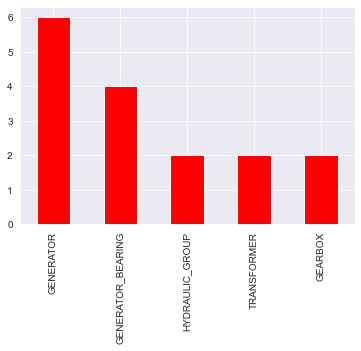

In [25]:
failures.Component.value_counts().plot(kind='bar', color='r')

## c) Failures/Turbine and component

Let's check if there's any turbine that particularly suffered from a certain failure.

In [26]:
failures_counts = failures.groupby('Turbine_ID').apply(
    lambda x: x.Component.value_counts())
failures_counts = failures_counts.unstack(fill_value=0)

In [27]:
failures_counts

,GEARBOX,GENERATOR,GENERATOR_BEARING,HYDRAULIC_GROUP,TRANSFORMER
Turbine_ID,,,,,
T01,1,0,0,0,0
T06,0,5,0,1,0
T07,0,0,1,0,2
T09,1,0,3,0,0
T11,0,1,0,1,0


<AxesSubplot:xlabel='Turbine_ID'>

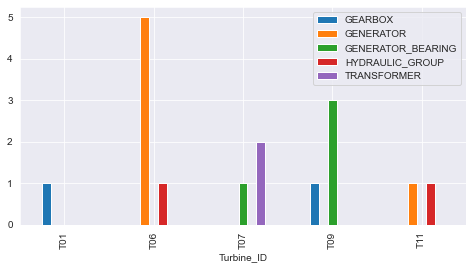

In [28]:
fig, ax = plt.subplots(figsize=(8,4))
failures_counts.plot(kind='bar', ax=ax)

The generator of Turbine T06 has failed 5 times while the generator bearing of turbine T09 failed 3 times!

## c) Failures/time

Let's check when the failures happened over time.

In [29]:
failures_timeline = failures.set_index('Timestamp').resample('M').Turbine_ID.apply(
    lambda x: x.value_counts())
failures_timeline = failures_timeline.unstack(fill_value=0)

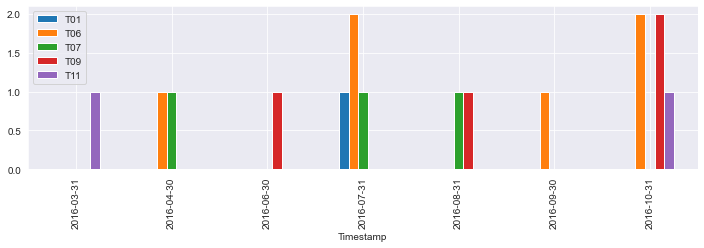

In [30]:
fig, ax = plt.subplots(figsize=(12,3))
failures_timeline.plot(kind='bar', ax=ax)
ax.set_xticklabels([i.get_text()[:10] for i in ax.get_xticklabels()])
plt.show()

## d) Failures/time & turbine

Let's see when the faults happened for different turbines by plotting the produced power generated by each.

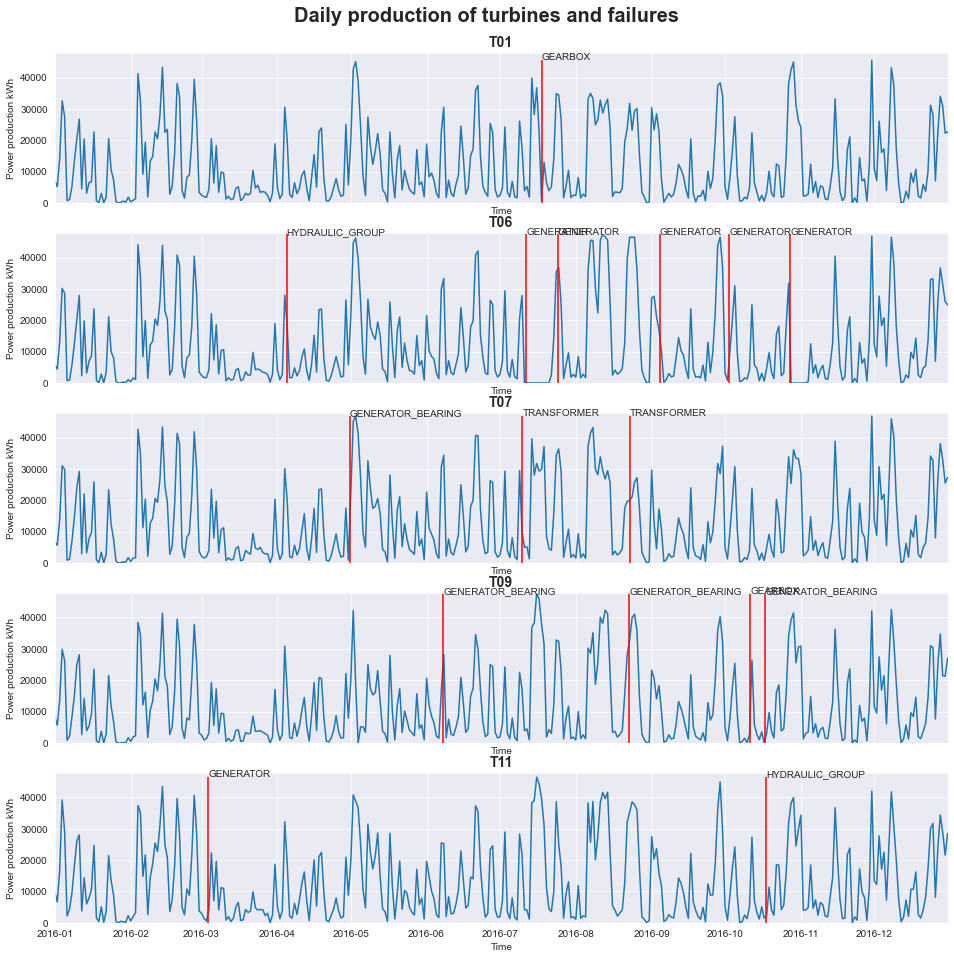

In [31]:
fig, axes = plt.subplots(figsize=(16,16), nrows=len(turbines), 
                         sharex=True, sharey=True)

for i, t in enumerate(turbines):
    energy_turbine = df.loc[t].Grd_Prod_Pwr_Avg.resample('D').sum() / 6
    failures_turbine = failures.loc[failures.Turbine_ID == t]
    ax = axes.ravel()[i]
    ax.plot(energy_turbine)
    ax.set_title(t, fontdict=dict(size=14, weight='bold'))
    
    ax.vlines(
        failures_turbine.Timestamp.values, 0, 
        energy_turbine.max(), color='red')
    for q, failure in failures_turbine.iterrows():
        ax.text(failure.Timestamp, energy_turbine.max(), failure.Component)
    
    ax.set_xlim(energy_turbine.index.min(), energy_turbine.index.max())
    ax.set_ylim(0)
    ax.set_ylabel("Power production kWh")
    ax.set_xlabel("Time")

plt.suptitle('Daily production of turbines and failures', 
             fontsize=20, fontweight='bold', y=.92)
plt.show()

# 4) Power curve

The power curve is a plot of the power produced by the generator (y axis) as a function of the wind speed (x axis). Often, when a failure occurs, the power production decreases or becomes null. Therefore, this plot can gives us insight about failures. However, it is not always sufficient to predict failures.

In [32]:
df = pd.read_csv(os.path.join(DATA_ROOT, DATA_SIGNAL))
df.head()
df.set_index('Timestamp', drop=True, inplace=True)
df.sort_index(inplace=True)
df.sort_values(by = ['Timestamp', 'Turbine_ID'], inplace=True)

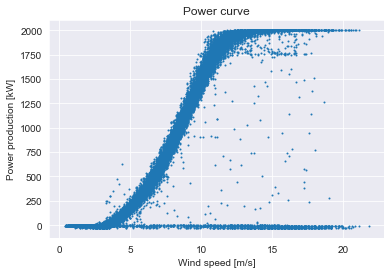

In [33]:
# Here's the code to plot the power curve.

fig, ax = plt.subplots()

ax.scatter(
    df[df["Turbine_ID"] == "T01"]["Amb_WindSpeed_Avg"],
    df[df["Turbine_ID"] == "T01"]["Grd_Prod_Pwr_Avg"],
    s=1
)
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Power production [kW]")
# _ = is a trick to stop jupyter from printing out text.
_ = ax.set_title("Power curve")

Based on the power curve in the figure above, we can determine the cut-in and the cut-out speed:

- The cut-in speed is the minimum wind speed that permits power production (on which the turbine starts rotation and generates power). Here it is approximately 4.5 m/s. 
- The cut-out speed is the minimum speed that permits maximum power production (the braking system is used to avoid rotor damage). Here it is approximately 12 m/s.

Therefore, we can note that many points have 0-power generation in the operating region of the turbine (between cut-in and cut-out speed). These points could correspond to when the turbine is stopped for maintenance.

Reference: *A part of this code was inspired by Gianluca Mauro, AI Academy, who developed a similar case study for KIC InnoEnergy SE.*